<a href="https://colab.research.google.com/github/vadaliah/CS5260/blob/master/VWAP%20ML%20Model%20Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Forex VWAP(Volume Weighted Average Price) ML Solution
This notebook demonstrates Machine Learning solution to predict VWAP direction for given currency pair based on historical volume dataset

Problem Formulation
In this example, we will use Historical Currencypair price volume dataset provided from FOREX Tester APP, available here: https://forextester.com/data/datasources.
The dataset contains Hourly pricing data of 6 currency pair (EURUSD, GBPUSD, AUDUSD, NZSUSD, USDJPY and USDCHF) for April 2018

Data Dictionary
  1  
 1   Ticker        CurrencyPair of the Trade
 2   BusinessDate  BusinessDate  
 3   TimeBucket    Hourly Time Bucket 
 4   TradeTime     Trade Time in HH:MM  
 5   TradePrice    Trade Price
 6   Open          Opening Price for the TimeBucket Interval
 8   High          High Price for the TimeBucket Interval
 9   Low           Low Price for the Time Bucket interval
 10   Close        Closing Price for the TimeBucket Interval
 11  AvgPrice      AvgPrice for the TimeBucket Interval
 12  PV            PriceVolume for the interval
 13  VWAP         Volume Weighted Avg Price for the interval
 14  Trend        "Goal" Trend of the price "UpTrend", DownTrend" 

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from google.colab import files
fx_volume_file = 'https://raw.githubusercontent.com/vadaliah/CS5260/master/currencypair_volume_datset.csv'
fx_volume_df = pd.read_csv(fx_volume_file)
fx_volume_df.sample(5)
print(fx_volume_df.shape)
print(fx_volume_df.size)
fx_volume_df.head().values

fx_trade_file = 'https://raw.githubusercontent.com/vadaliah/CS5260/master/trade_dataset.csv'
fx_trade_df = pd.read_csv(fx_trade_file)
fx_trade_df = fx_trade_df.replace(r'^\s*$', np.nan, regex=True)  # Trim trailing spaces
fx_trade_df.dropna() # Drop nan records
print(fx_trade_df.shape)
print(fx_trade_df.size)
fx_trade_df.head().values


(3013, 8)
24104
(13152, 13)
170976


array([['USDJPY', 20180401, '21:00', 2101, 106.167, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'DownTrend'],
       ['USDJPY', 20180401, '21:00', 2102, 106.189, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'DownTrend'],
       ['USDJPY', 20180401, '21:00', 2105, 106.221, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'UpTrend'],
       ['USDJPY', 20180401, '21:00', 2106, 106.219, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'UpTrend'],
       ['USDJPY', 20180401, '21:00', 2107, 106.222, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'UpTrend']],
      dtype=object)

In [4]:
	fx_volume_df.info()
	fx_volume_df.columns
	fx_volume_df['Ticker'].value_counts()
	fx_volume_df[['Ticker','BusinessDate','TimeBucket']].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3013 entries, 0 to 3012
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ticker        3013 non-null   object 
 1   BusinessDate  3013 non-null   int64  
 2   TimeBucket    3013 non-null   object 
 3   Open          3013 non-null   float64
 4   High          3013 non-null   float64
 5   Low           3013 non-null   float64
 6   Close         3013 non-null   float64
 7   Volume        3013 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 188.4+ KB


Ticker  BusinessDate  TimeBucket
GBPUSD  20180406      20:00         2
NZDUSD  20180410      20:00         2
USDCHF  20180406      10:00         2
NZDUSD  20180410      10:00         2
        20180427      10:00         2
                                   ..
EURUSD  20180430      18:00         1
                      19:00         1
                      1:00          1
                      20:00         1
USDJPY  20180430      9:00          1
Length: 2831, dtype: int64

In [5]:
	fx_trade_df.info()
	fx_trade_df.columns
	fx_trade_df['Ticker'].value_counts()
	fx_trade_df[['Ticker','BusinessDate','TimeBucket']].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13152 entries, 0 to 13151
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ticker        13152 non-null  object 
 1   BusinessDate  13152 non-null  int64  
 2   TimeBucket    13152 non-null  object 
 3   TradeTime     13152 non-null  int64  
 4   TradePrice    13152 non-null  float64
 5   Open          13152 non-null  float64
 6   High          13152 non-null  float64
 7   Low           13152 non-null  float64
 8   Close         13152 non-null  float64
 9   AvgPrice      13152 non-null  float64
 10  PV            13152 non-null  float64
 11  VWAP          13152 non-null  float64
 12  Trend         13152 non-null  object 
dtypes: float64(8), int64(2), object(3)
memory usage: 1.3+ MB


Ticker  BusinessDate  TimeBucket
USDJPY  20180430      10:00         93
EURUSD  20180420      10:00         93
AUDUSD  20180430      10:00         93
NZDUSD  20180420      11:00         93
                      10:00         93
                                    ..
        20180430      5:00          13
EURUSD  20180420      5:00          13
NZDUSD  20180430      4:00          13
EURUSD  20180420      4:00          13
GBPUSD  20180420      4:00          13
Length: 220, dtype: int64

	Exploratory Data Anaysis
	1. Ensure data is complete, verify presence of data for all 6 currency pair is present in the volume dataset
	2. Verify count of data by currencypair, businessdate combination. Any currencypair with insufficient data will skew VWAP results and result in inaccurate model outcome
  3. Verify Trading dataset is complete, contains currency pair and business dates in scope
	

UpTrend      7383
DownTrend    5769
Name: Trend, dtype: int64

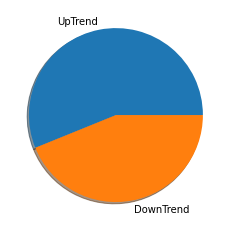

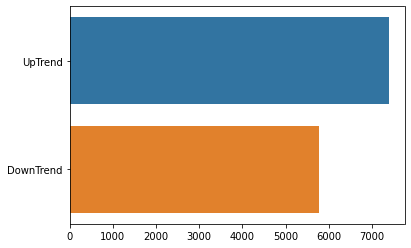

In [6]:
trend_counts =fx_trade_df['Trend'].value_counts()
display(trend_counts)
plt.pie(trend_counts,labels=trend_counts.index,shadow=True )
plt.show()
sns.barplot(y=trend_counts.index, x=trend_counts.values,orient='h')

EURUSD    2700
NZDUSD    2665
GBPUSD    2606
AUDUSD    2604
USDJPY    2577
Name: Ticker, dtype: int64

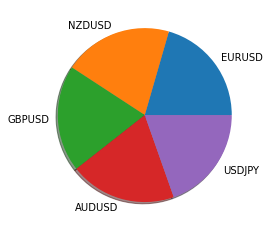

Ticker  BusinessDate
NZDUSD  20180430        1390
EURUSD  20180430        1358
GBPUSD  20180430        1311
AUDUSD  20180430        1310
USDJPY  20180430        1305
EURUSD  20180420        1164
AUDUSD  20180420        1118
GBPUSD  20180420        1118
NZDUSD  20180420        1118
USDJPY  20180420        1116
EURUSD  20180401         178
GBPUSD  20180401         177
AUDUSD  20180401         176
NZDUSD  20180401         157
USDJPY  20180401         156
dtype: int64

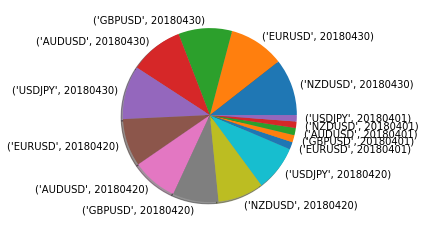

In [7]:
# Plot of Trade Data to visualize currency pair(Ticker) and data count for CurrencyPair, Business Date
ticker_counts =fx_trade_df['Ticker'].value_counts()
display(ticker_counts)
plt.pie(ticker_counts,labels=ticker_counts.index,shadow=True )
plt.show()

ticker_counts =fx_trade_df[['Ticker','BusinessDate']].value_counts()
display(ticker_counts)
plt.pie(ticker_counts,labels=ticker_counts.index,shadow=True )
plt.show()



EURUSD    507
USDJPY    502
USDCHF    502
NZDUSD    502
AUDUSD    500
GBPUSD    500
Name: Ticker, dtype: int64

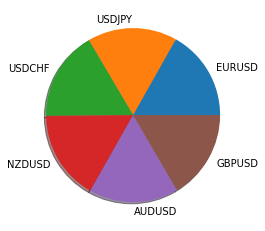

Ticker  BusinessDate
USDJPY  20180430        24
GBPUSD  20180417        24
NZDUSD  20180409        24
        20180405        24
        20180404        24
                        ..
USDCHF  20180401         3
        20180408         3
        20180415         3
        20180422         3
NZDUSD  20180401         3
Length: 156, dtype: int64

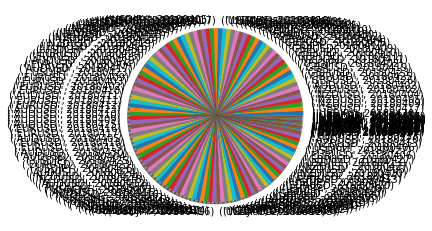

In [ ]:
# Plot of Volume Data to visualize currency pair(Ticker) 
# Plot of data count for CurrencyPair, Business Date
ticker_counts =fx_volume_df['Ticker'].value_counts()
display(ticker_counts)
plt.pie(ticker_counts,labels=ticker_counts.index,shadow=True )
plt.show()

ticker_counts =fx_volume_df[['Ticker','BusinessDate']].value_counts()
display(ticker_counts)
plt.pie(ticker_counts,labels=ticker_counts.index,shadow=True )
plt.show()
#sns.barplot(y=ticker_counts.index, x=ticker_counts.values,orient='h')

In [2]:
#Feature Engineering
# Compute Avg Price = Avg(open,close,high,low)
#fx_volume_df.set_index(['Open', 'Close','High','Low'], append=True)
fx_volume_df['AvgPrice'] = fx_volume_df[['Open', 'Close','High','Low']].mean(axis=1)


# Compute Consolidate Key of Ticker, BusinessDate, TimeBucke
fx_volume_df['Key'] = fx_volume_df['Ticker']+"-"+fx_volume_df['BusinessDate'].astype(str)+"-"+fx_volume_df['TimeBucket'].astype(str)
fx_volume_df.head()


,Ticker,BusinessDate,TimeBucket,Open,High,Low,Close,Volume,AvgPrice,Key
0,AUDUSD,20180401,21:00,0.76855,0.76928,0.76844,0.76888,356150000,0.768787,AUDUSD-20180401-21:00
1,AUDUSD,20180401,22:00,0.76884,0.76884,0.76834,0.76859,830980000,0.768652,AUDUSD-20180401-22:00
2,AUDUSD,20180401,23:00,0.76856,0.76860,0.76807,0.76828,1865340000,0.768377,AUDUSD-20180401-23:00
3,AUDUSD,20180402,0:00,0.76828,0.76946,0.76817,0.76929,2957570000,0.768800,AUDUSD-20180402-0:00
4,AUDUSD,20180402,10:00,0.76927,0.76947,0.76821,0.76843,2352190000,0.768845,AUDUSD-20180402-10:00


In [11]:
# Train Test Split
from sklearn.model_selection import train_test_split
class_column = ['Trend']
random_seed = 500
features = fx_trade_df.drop(columns=class_column)
target = fx_trade_df[class_column]
fx_trade_df=fx_trade_df.dropna()
X_train, X_test, y_train,y_test = train_test_split(features,target,test_size=.25,random_state = random_seed,stratify=fx_trade_df[class_column])

In [12]:
print("on X Train")
print ("X train dimensions", X_train.shape)
display(X_train.head())

print ("on x test")
print ("x test dimensions", X_test.shape)
display(X_test.head())


on X Train
X train dimensions (9864, 12)


,Ticker,BusinessDate,TimeBucket,TradeTime,TradePrice,Open,High,Low,Close,AvgPrice,PV,VWAP
866,USDJPY,20180420,14:00,1414,107.71200,107.79000,107.85500,107.69100,107.69800,107.758500,107.758500,107.758500
12890,AUDUSD,20180430,19:00,1937,0.75255,0.75296,0.75306,0.75249,0.75269,0.752800,0.752800,0.752800
8463,GBPUSD,20180420,17:00,656,1.40659,1.40371,1.40381,1.40211,1.40329,1.403230,1.403230,1.403230
10946,AUDUSD,20180420,19:00,434,0.77161,0.76673,0.76696,0.76630,0.76668,0.766667,0.766667,0.766667
6792,NZDUSD,20180430,17:00,416,0.70757,0.70511,0.70516,0.70370,0.70411,0.704520,0.704520,0.704520


on x test
x test dimensions (3288, 12)


,Ticker,BusinessDate,TimeBucket,TradeTime,TradePrice,Open,High,Low,Close,AvgPrice,PV,VWAP
2391,USDJPY,20180430,20:00,2052,109.31900,109.31600,109.33600,109.28300,109.33000,109.316250,109.316250,109.316250
2581,EURUSD,20180401,21:00,2104,1.23172,1.23199,1.23230,1.23165,1.23204,1.231995,1.231995,1.231995
6881,NZDUSD,20180430,7:00,556,0.70798,0.70735,0.70739,0.70621,0.70654,0.706873,0.706873,0.706873
3062,EURUSD,20180420,7:00,553,1.23405,1.23422,1.23529,1.23244,1.23249,1.233610,1.233610,1.233610
3293,EURUSD,20180420,10:00,1034,1.23025,1.23013,1.23029,1.22930,1.23024,1.229990,1.229990,1.229990


In [13]:
# y_test.dropna() # Drop nan records
# y_test.fillna("EMPTY")
print("on Y Train")
print ("Y train dimensions", y_train.shape)
display(y_train.head())

print ("on Y test")
print ("Y test dimensions", y_test.shape)
display(y_test.head())


on Y Train
Y train dimensions (9864, 1)


,Trend
866,DownTrend
12890,DownTrend
8463,UpTrend
10946,UpTrend
6792,UpTrend


on Y test
Y test dimensions (3288, 1)


,Trend
2391,UpTrend
2581,DownTrend
6881,UpTrend
3062,UpTrend
3293,UpTrend


In [9]:
# machine learning libs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler, LabelEncoder
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [14]:
from sklearn import preprocessing 
le = LabelEncoder()

for i in range(0,X_test.shape[1]):
    if X_test.dtypes[i]=='object':
        X_test[X_test.columns[i]] = le.fit_transform(X_test[X_test.columns[i]])

print (X_test.head())

      Ticker  BusinessDate  TimeBucket  TradeTime  TradePrice       Open  \
2391       4      20180430          12       2052   109.31900  109.31600   
2581       1      20180401          13       2104     1.23172    1.23199   
6881       3      20180430          21        556     0.70798    0.70735   
3062       1      20180420          21        553     1.23405    1.23422   
3293       1      20180420           1       1034     1.23025    1.23013   

          High         Low      Close    AvgPrice          PV        VWAP  
2391  109.33600  109.28300  109.33000  109.316250  109.316250  109.316250  
2581    1.23230    1.23165    1.23204    1.231995    1.231995    1.231995  
6881    0.70739    0.70621    0.70654    0.706873    0.706873    0.706873  
3062    1.23529    1.23244    1.23249    1.233610    1.233610    1.233610  
3293    1.23029    1.22930    1.23024    1.229990    1.229990    1.229990  


In [15]:
from sklearn import preprocessing 
le = LabelEncoder()

for i in range(0,X_train.shape[1]):
    if X_train.dtypes[i]=='object':
        X_train[X_train.columns[i]] = le.fit_transform(X_train[X_train.columns[i]])

print (X_train.head())

       Ticker  BusinessDate  TimeBucket  TradeTime  TradePrice       Open  \
866         4      20180420           5       1414   107.71200  107.79000   
12890       0      20180430          10       1937     0.75255    0.75296   
8463        2      20180420           8        656     1.40659    1.40371   
10946       0      20180420          10        434     0.77161    0.76673   
6792        3      20180430           8        416     0.70757    0.70511   

           High         Low      Close    AvgPrice          PV        VWAP  
866    107.85500  107.69100  107.69800  107.758500  107.758500  107.758500  
12890    0.75306    0.75249    0.75269    0.752800    0.752800    0.752800  
8463     1.40381    1.40211    1.40329    1.403230    1.403230    1.403230  
10946    0.76696    0.76630    0.76668    0.766667    0.766667    0.766667  
6792     0.70516    0.70370    0.70411    0.704520    0.704520    0.704520  


In [21]:
from sklearn import preprocessing 
le = LabelEncoder()

if y_test.dtypes[0]=='object':
    y_test[y_test.columns[0]] = le.fit_transform(y_test[y_test.columns[0]])

print (y_test.head())


      Trend
2391      1
2581      0
6881      1
3062      1
3293      1


In [32]:
y_test.value_counts()

Trend
1        1846
0        1442
dtype: int64

In [22]:
from sklearn import preprocessing 
le = LabelEncoder()

if y_train.dtypes[0]=='object':
    y_train[y_train.columns[0]] = le.fit_transform(y_train[y_train.columns[0]])

print (y_train.head())

       Trend
866        0
12890      0
8463       1
10946      1
6792       1


Accuracy of LR classifier on training set: 0.56
Accuracy of LR classifier on test set: 0.56
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1442
           1       0.56      1.00      0.72      1846

    accuracy                           0.56      3288
   macro avg       0.28      0.50      0.36      3288
weighted avg       0.32      0.56      0.40      3288



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


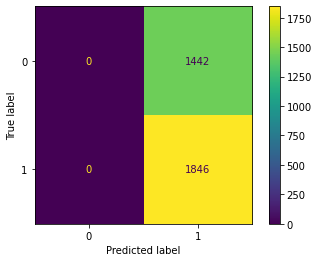

In [30]:
# Modelling
# TO Do - OneHotEncoding of Ticker column
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

random_seed = 42

lr = LogisticRegression(random_state=random_seed)
lr.fit(X_train, y_train.values.ravel()) # y = f(x)
print('Accuracy of LR classifier on training set: {:.2f}'.format(lr.score(X_train, y_train)))
print('Accuracy of LR classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)))

pred = lr.predict(X_test)

print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, lr.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

plt.show()

Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.99
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1442
           1       0.99      0.99      0.99      1846

    accuracy                           0.99      3288
   macro avg       0.98      0.98      0.98      3288
weighted avg       0.99      0.99      0.99      3288



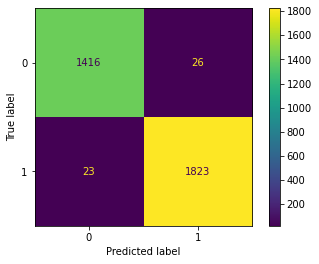

In [34]:
#Random Forest Model Selection
from sklearn.ensemble import RandomForestClassifier

random_seed = 42

rf = RandomForestClassifier(random_state=random_seed)
rf.fit(X_train, y_train.values.ravel())
print('Accuracy of RF classifier on training set: {:.2f}'.format(rf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))

pred = rf.predict(X_test)

print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, rf.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()

plt.show()

In [16]:
# machine learning libs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [17]:
fx_trade_file = 'https://raw.githubusercontent.com/vadaliah/CS5260/master/trade_dataset.csv'
fx_trade_df = pd.read_csv(fx_trade_file)
fx_trade_df = fx_trade_df.replace(r'^\s*$', np.nan, regex=True)  # Trim trailing spaces
fx_trade_df.dropna() # Drop nan records
print(fx_trade_df.shape)
print(fx_trade_df.size)
fx_trade_df.head().values


(13152, 13)
170976


array([['USDJPY', 20180401, '21:00', 2101, 106.167, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'DownTrend'],
       ['USDJPY', 20180401, '21:00', 2102, 106.189, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'DownTrend'],
       ['USDJPY', 20180401, '21:00', 2105, 106.221, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'UpTrend'],
       ['USDJPY', 20180401, '21:00', 2106, 106.219, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'UpTrend'],
       ['USDJPY', 20180401, '21:00', 2107, 106.222, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'UpTrend']],
      dtype=object)

In [18]:
# Train Test Split
from sklearn.model_selection import train_test_split
class_column = ['Trend']
random_seed = 500
features = fx_trade_df.drop(columns=class_column)
target = fx_trade_df[class_column]
fx_trade_df=fx_trade_df.dropna()
X_train, X_test, y_train,y_test = train_test_split(features,target,test_size=.25,random_state = random_seed,stratify=fx_trade_df[class_column])

In [112]:
#Establishing pipeline
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                  ('onehot_cat', OneHotEncoder())])

In [113]:
# now we establish preprocessing pipe by columns

cat_cols = ['Ticker','TimeBucket']
# num_cols = ['BusinessDate','TimeBucket','TradePrice','VWAP']

preproc = ColumnTransformer([('cat_pipe', cat_pipeline, cat_cols)],
                             remainder='passthrough')

In [114]:
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', LogisticRegression(random_state=random_seed))])

# visualization of the pipeline
with config_context(display='diagram'):
    display(pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  ['Ticker', 'TimeBucket'])])),
                ('mdl', LogisticRegression(random_state=500))])

In [12]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [22]:
from sklearn import preprocessing 
le = LabelEncoder()

for i in range(0,X_test.shape[1]):
    if X_test.dtypes[i]=='object':
        X_test[X_test.columns[i]] = le.fit_transform(X_test[X_test.columns[i]])

print (X_test.head())

for i in range(0,X_test.shape[1]):
    if X_train.dtypes[i]=='object':
        X_train[X_train.columns[i]] = le.fit_transform(X_train[X_train.columns[i]])

print (X_train.head())



      Ticker  BusinessDate  TimeBucket  TradeTime  TradePrice       Open  \
2391       4      20180430          12       2052   109.31900  109.31600   
2581       1      20180401          13       2104     1.23172    1.23199   
6881       3      20180430          21        556     0.70798    0.70735   
3062       1      20180420          21        553     1.23405    1.23422   
3293       1      20180420           1       1034     1.23025    1.23013   

          High         Low      Close    AvgPrice          PV        VWAP  
2391  109.33600  109.28300  109.33000  109.316250  109.316250  109.316250  
2581    1.23230    1.23165    1.23204    1.231995    1.231995    1.231995  
6881    0.70739    0.70621    0.70654    0.706873    0.706873    0.706873  
3062    1.23529    1.23244    1.23249    1.233610    1.233610    1.233610  
3293    1.23029    1.22930    1.23024    1.229990    1.229990    1.229990  
       Ticker  BusinessDate  TimeBucket  TradeTime  TradePrice       Open  \
866       

In [145]:
pipelineLR = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, penalty='l2', solver='lbfgs'))
#
# Create the parameter grid
#
param_grid_lr = [{
    'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
}]
#
# Create an instance of GridSearch Cross-validation estimator
#
gsLR = GridSearchCV(estimator=pipelineLR,
                     param_grid = param_grid_lr,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)
#
# Train the LogisticRegression Classifier
#
gsLR = gsLR.fit(X_train, y_train)
#
# Print the training score of the best model
#
print(gsLR.best_score_)
#
# Print the model parameters of the best model
#
print(gsLR.best_params_)
#
# Print the test score of the best model
#
clfLR = gsLR.best_estimator_
print('Test accuracy: %.3f' % clfLR.score(X_test, y_test))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.5788758937177219
{'logisticregression__C': 0.001}
Test accuracy: 0.582


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [23]:
pipelineRFC = make_pipeline(StandardScaler(), RandomForestClassifier(criterion='gini', random_state=1))
#
# Create the parameter grid
#
param_grid_rfc = [{
    'randomforestclassifier__max_depth':[2, 3, 4],
    'randomforestclassifier__max_features':[2, 3, 4, 5, 6]
}]
#
# Create an instance of GridSearch Cross-validation estimator
#
gsRFC = GridSearchCV(estimator=pipelineRFC,
                     param_grid = param_grid_rfc,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)
#
# Train the RandomForestClassifier
#
gsRFC = gsRFC.fit(X_train, y_train)
#
# Print the training score of the best model
#
print(gsRFC.best_score_)
#
# Print the model parameters of the best model
#
print(gsRFC.best_params_)
#
# Print the test score of the best model
#
clfRFC = gsRFC.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(X_test, y_test))

/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

0.721918099594937
{'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': 6}
Test accuracy: 0.723


In [ ]:
pipelineSVC = make_pipeline(StandardScaler(), SVC(random_state=1))
#
# Create the parameter grid
#
param_grid_svc = [{
                    'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__kernel': ['linear']
                  },
                 {
                    'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__kernel': ['rbf']
                 }]
#
# Create an instance of GridSearch Cross-validation estimator
#
gsSVC = GridSearchCV(estimator=pipelineSVC,
                     param_grid = param_grid_svc,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)
#
# Train the SVM classifier
#
gsSVC.fit(X_train, y_train)
#
# Print the training score of the best model
#
print(gsSVC.best_score_)
#
# Print the model parameters of the best model
#
print(gsSVC.best_params_)
#
# Print the model score on the test data using GridSearchCV score method
#
print('Test accuracy: %.3f' % gsSVC.score(X_test, y_test))
#
# Print the model score on the test data using Best estimator instance
#
clfSVC = gsSVC.best_estimator_
print('Test accuracy: %.3f' % clfSVC.score(X_test, y_test))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.8687164374186945
{'svc__C': 10.0, 'svc__gamma': 10.0, 'svc__kernel': 'rbf'}
Test accuracy: 0.870



Gridsearch Results for the models (Assignment 5)
 

*   LogisticRegression:

1.   training score: 0.5788758937177219
2.   Model Parameter: {'logisticregression__C': 0.001}
3.   Test accuracy: 0.582

*   RandomForestClassifier
1.   training score: 0.721918099594937
2.   Model Parameter: {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': 6}
3.   Test accuracy:  0.723
 
GridSearchCV WITH optimal hyper parameters
- improved model accuracy for LogisticRegression improving accruacy to 58% from 56%
- Random Forest accuracy reduced to 72%  which was not expected, Further parameter tuning is required to determine cause


Assignment 5  Conclusion:
By using GridSearchCV WITH optimal hyper parameters improved model accuracy for
- LogisticRegression to 58% from 56%
- Random Forest accuracy reduced to 72% which was not expected, Further parameter tuning is required to determine cause

In [16]:
# machine learning libs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [5]:
fx_trade_file = 'https://raw.githubusercontent.com/vadaliah/CS5260/master/trade_dataset.csv'
fx_trade_df = pd.read_csv(fx_trade_file)
fx_trade_df = fx_trade_df.replace(r'^\s*$', np.nan, regex=True)  # Trim trailing spaces
fx_trade_df.dropna() # Drop nan records
print(fx_trade_df.shape)
print(fx_trade_df.size)
fx_trade_df.head().values

(13152, 13)
170976


array([['USDJPY', 20180401, '21:00', 2101, 106.167, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'DownTrend'],
       ['USDJPY', 20180401, '21:00', 2102, 106.189, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'DownTrend'],
       ['USDJPY', 20180401, '21:00', 2105, 106.221, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'UpTrend'],
       ['USDJPY', 20180401, '21:00', 2106, 106.219, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'UpTrend'],
       ['USDJPY', 20180401, '21:00', 2107, 106.222, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'UpTrend']],
      dtype=object)

In [7]:
#Feature Engineering for Assignment 6
#Feature Engineering



# Add a Consoliidated Key of Ticker, BusinessDate, TimeBucket 
# Likely result in ordering of records by ticket, businessdate and timebucket values
fx_trade_df['Key'] = fx_trade_df['Ticker']+"-"+fx_trade_df['BusinessDate'].astype(str)+"-"+fx_trade_df['TimeBucket'].astype(str)
fx_trade_df.head()
print(fx_trade_df)


       Ticker  BusinessDate TimeBucket  TradeTime  TradePrice       Open  \
0      USDJPY      20180401      21:00       2101   106.16700  106.16700   
1      USDJPY      20180401      21:00       2102   106.18900  106.16700   
2      USDJPY      20180401      21:00       2105   106.22100  106.16700   
3      USDJPY      20180401      21:00       2106   106.21900  106.16700   
4      USDJPY      20180401      21:00       2107   106.22200  106.16700   
...       ...           ...        ...        ...         ...        ...   
13147  AUDUSD      20180430      23:00       2355     0.75328    0.75285   
13148  AUDUSD      20180430      23:00       2356     0.75320    0.75285   
13149  AUDUSD      20180430      23:00       2357     0.75318    0.75285   
13150  AUDUSD      20180430      23:00       2358     0.75314    0.75285   
13151  AUDUSD      20180430      23:00       2359     0.75315    0.75285   

           High        Low      Close    AvgPrice          PV        VWAP  \
0      106

Unit Test Validation:
- consolidated key represents combination of  of Ticker, BusinessDate and TimeBucket Key values. Unit Testing will entails comparision of Key against individual fields in the key

In [10]:
#Feature Engineering
# Add a Boolean variable DirectionFlag to indicate whether TradedPrice is higher then Volume weighted average price(VWAP)
# DirectionFlag is expected to aid the model in Trend prediction and improve model accuracy
%timeit fx_trade_df['DirectionFlag'] = np.where(fx_trade_df['TradePrice'] >= fx_trade_df['VWAP'] , 1, 0)
fx_trade_df.head()
print(fx_trade_df)

373 µs ± 9.33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
       Ticker  BusinessDate TimeBucket  TradeTime  TradePrice       Open  \
0      USDJPY      20180401      21:00       2101   106.16700  106.16700   
1      USDJPY      20180401      21:00       2102   106.18900  106.16700   
2      USDJPY      20180401      21:00       2105   106.22100  106.16700   
3      USDJPY      20180401      21:00       2106   106.21900  106.16700   
4      USDJPY      20180401      21:00       2107   106.22200  106.16700   
...       ...           ...        ...        ...         ...        ...   
13147  AUDUSD      20180430      23:00       2355     0.75328    0.75285   
13148  AUDUSD      20180430      23:00       2356     0.75320    0.75285   
13149  AUDUSD      20180430      23:00       2357     0.75318    0.75285   
13150  AUDUSD      20180430      23:00       2358     0.75314    0.75285   
13151  AUDUSD      20180430      23:00       2359     0.75315    0.75285   

           High

Unit Test Validation:
- DirectionFlag represents comparision of TradePrice against VWAP price. Unit Test entails validation of computation and ideally DirectionFlag should match Trend values

In [11]:
# Train Test Split
from sklearn.model_selection import train_test_split
class_column = ['Trend']
random_seed = 500
features = fx_trade_df.drop(columns=class_column)
target = fx_trade_df[class_column]
fx_trade_df=fx_trade_df.dropna()
X_train, X_test, y_train,y_test = train_test_split(features,target,test_size=.25,random_state = random_seed,stratify=fx_trade_df[class_column])

In [17]:
from sklearn import preprocessing 
le = LabelEncoder()

for i in range(0,X_test.shape[1]):
    if X_test.dtypes[i]=='object':
        X_test[X_test.columns[i]] = le.fit_transform(X_test[X_test.columns[i]])

print (X_test.head())

for i in range(0,X_test.shape[1]):
    if X_train.dtypes[i]=='object':
        X_train[X_train.columns[i]] = le.fit_transform(X_train[X_train.columns[i]])

print (X_train.head())


      Ticker  BusinessDate  TimeBucket  TradeTime  TradePrice       Open  \
2391       4      20180430          12       2052   109.31900  109.31600   
2581       1      20180401          13       2104     1.23172    1.23199   
6881       3      20180430          21        556     0.70798    0.70735   
3062       1      20180420          21        553     1.23405    1.23422   
3293       1      20180420           1       1034     1.23025    1.23013   

          High         Low      Close    AvgPrice          PV        VWAP  \
2391  109.33600  109.28300  109.33000  109.316250  109.316250  109.316250   
2581    1.23230    1.23165    1.23204    1.231995    1.231995    1.231995   
6881    0.70739    0.70621    0.70654    0.706873    0.706873    0.706873   
3062    1.23529    1.23244    1.23249    1.233610    1.233610    1.233610   
3293    1.23029    1.22930    1.23024    1.229990    1.229990    1.229990   

      Key  DirectionFlag  
2391  209              1  
2581   43              0  

In [18]:
pipelineLR = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, penalty='l2', solver='lbfgs'))
#
# Create the parameter grid
#
param_grid_lr = [{
    'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
}]
#
# Create an instance of GridSearch Cross-validation estimator
#
gsLR = GridSearchCV(estimator=pipelineLR,
                     param_grid = param_grid_lr,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)
#
# Train the LogisticRegression Classifier
#
gsLR = gsLR.fit(X_train, y_train)
#
# Print the training score of the best model
#
print(gsLR.best_score_)
#
# Print the model parameters of the best model
#
print(gsLR.best_params_)
#
# Print the test score of the best model
#
clfLR = gsLR.best_estimator_
print('Test accuracy: %.3f' % clfLR.score(X_test, y_test))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

1.0
{'logisticregression__C': 0.001}
Test accuracy: 1.000


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
pipelineRFC = make_pipeline(StandardScaler(), RandomForestClassifier(criterion='gini', random_state=1))
#
# Create the parameter grid
#
param_grid_rfc = [{
    'randomforestclassifier__max_depth':[2, 3, 4],
    'randomforestclassifier__max_features':[2, 3, 4, 5, 6]
}]
#
# Create an instance of GridSearch Cross-validation estimator
#
gsRFC = GridSearchCV(estimator=pipelineRFC,
                     param_grid = param_grid_rfc,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)
#
# Train the RandomForestClassifier
#
gsRFC = gsRFC.fit(X_train, y_train)
#
# Print the training score of the best model
#
print(gsRFC.best_score_)
#
# Print the model parameters of the best model
#
print(gsRFC.best_params_)
#
# Print the test score of the best model
#
clfRFC = gsRFC.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(X_test, y_test))

/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

1.0
{'randomforestclassifier__max_depth': 2, 'randomforestclassifier__max_features': 4}
Test accuracy: 1.000


Gridsearch Results for the models

**LogisticRegression:**

Model Parameter: {'logisticregression__C': 0.001}
 Test accuracy: 1.000

**RandomForestClassifier:**
training score: 0.721918099594937
Model Parameter: {'randomforestclassifier__max_depth': 2, 'randomforestclassifier__max_features': 4}
Test accuracy: 1.000




Conclusion:
By adding additional features, we were able to improve model accuracy to 100% for both  LogisticRegression and 
Random Forest  over GridSearchCV results of Assignment 5


- LogisticRegression accuracy increased to 100% from 58%
- Random Forest accuracy accuracy increased  to 100% from 72% 